## solar collisions and MCDA testing

In [1]:
import os
import pyvista as pv
import trimesh as tm
import numpy as np
import ladybug as lb
from ladybug.sunpath import Sunpath


In [2]:
# load context file. Currently set as Rotterdam area from spatial computing
context_path = os.path.relpath('../data/immediate_context.obj')
context = tm.load(context_path)

In [3]:
# generate solar postitions using ladybug library
# calculate collisions with envelope
# calculate collisions with context

la = 52.0116 # lattitude
lo = 4.3571  # longtitude
sunpath = Sunpath(la, lo)
hoys = []
sun_vectors = []

for d in range(365): # for all days in a year, note that this does not take into account leap years
    if d%30 == 0: # each month, note that this does not take into account the different month lengths
        for h in range(24): # the hours of that day, note that this does not take into account the real length of the day
            i = d*24+h # the current hour of the year (hoy)
            sun = sunpath.calculate_sun_from_hoy(i)
            sun_vector = sun.sun_vector.to_array()
            if sun_vector[2] < 0.0:
                hoys.append(i)
                sun_vectors.append(sun_vector)

ALT./CRIT.,autonomy (max) W.0.5,comfort (max) W.0.05,price (min) W.0.46
VW,1,2,3
Ford,4,5,6


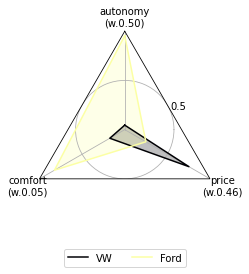

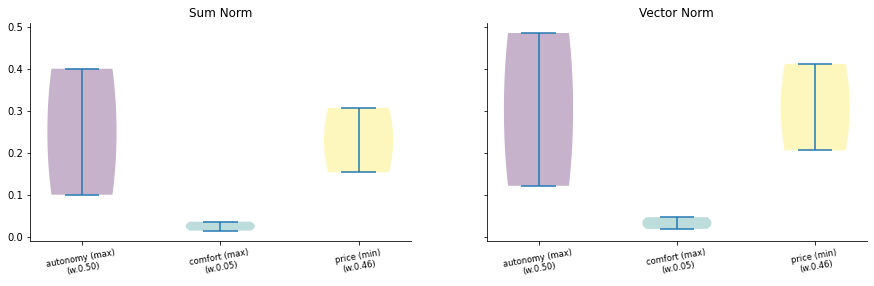

In [4]:
# My first Data Object:
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple
# 2 alternatives with 3 criteria
mtx = [
    [1,2,3], # first alternative (car 1)
    [4,5,6], # second alternative (car 2)
]

# first two alternatives are maximization, last one minimization
criteria = [MAX, MAX, MIN] # can also be criteria = [1, 1, -1]

# combine the two vectors:
data = Data(mtx, [min, max, min]) # could also be array: [-1, 1, -1]

# give the rows/columns names:
data =  Data(mtx, criteria,
        anames=["car 0", "car 1"],
        cnames=["autonomy", "comfort", "price"])

# add weights parameters to the model:
data =  Data(mtx, criteria,
        weights=[.5, .05, .46], # more than 1 in total --> problem?
        anames=["car 0", "car 1"],
        cnames=["autonomy", "comfort", "price"])

# change model values/names you need to copy the values:
data =  Data(data.mtx, data.criteria,
        weights=data.weights,
        anames=["VW", "Ford"],
        cnames=data.cnames)
data.plot.radar(cmap="inferno", show_criteria=False);

# rank toy data by weighted sum model, weighted product model, TOPSIS
# first we create the decision maker
dm = simple.WeightedSum()

# decide ranking:
dec = dm.decide(data)
dec.e_.points # gives the results for each alternative
dec.rank_ # ranking as numpy array
dec.best_alternative_, data.anames[dec.best_alternative_] # index of the row of the best alternative
dec.best_alternative_, data.anames[dec.best_alternative_]

# weighted product model
dm = simple.WeightedProduct()
dec = dm.decide(data)
dec.e_.points # gives the sums of log instead of products, results for each alternative

# TOPSIS model
dm = closeness.TOPSIS()
dec = dm.decide(data)

# compare two normalizations
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Sum Norm")
data.plot.violin(mnorm="sum", ax=ax1);

ax2.set_title("Vector Norm")
data.plot.violin(mnorm="vector", ax=ax2);
f.set_figwidth(15)

data

In [5]:
# sklearn linear regression model
import sklearn
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])
reg.coef_
reg.rank_

1

In [9]:
# SIMUS tutorial (sequential interactive model for urban systems)
# successive scenarios formulated as linear programs
# criteria = new jobs positions, green spaces max 500, financial feasibility, environmental impact
# all should be maximized

# first lets import the DATA class
from skcriteria import Data

data = Data(
    # the alternative matrix
    mtx=[
        [250, 120, 20, 800],
        [130, 200, 40, 1000],
        [350, 340, 15, 600]],

    # optimal sense
    criteria=[max, max, min, max],

    # names of alternatives and criteria
    anames=["Prj 1", "Prj 2", "Prj 3"],
    cnames=["jobs", "green", "fin", "env"])

# show the data object
data

# import the class - problem with the SIMUS - PuLP solver, ELECTRE is used instead

from skcriteria.madm.electre import ELECTRE1
dm = ELECTRE1()
dec = dm.decide(data)
dec


ALT./CRIT.,jobs (max),green (max),fin (min),env (max),Kernel
Prj 1,250,120,20,800,
Prj 2,130,200,40,1000,@
Prj 3,350,340,15,600,@


In [7]:
# convert to trimesh definition, taken from spatial computing workshop
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

# Visualize the mesh using pyvista plotter

# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the base mesh: light blue
p.add_mesh(tri_to_pv(context), color='#abd8ff')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]